### Starbucks Capstone Challenge
# Model Training

This notebook aims to train the models proposed to classify offers as appropriate or not.

## Define functions to train the classifiers

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN, RecurrentNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [3]:
def validate(model, dataloader=valid_dataloader, verbose=False):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for features, targets in dataloader:
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            valid_loss += criterion(prediction, targets)

            prediction = torch.sigmoid(prediction)
            prediction = prediction.round()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= len(dataloader)

        if verbose:
            print(f'\tValidation ... loss: {valid_loss:7.4f}')
            print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
            print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
            print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
            print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}'
                  .format((TP+TN)/float(POS+NEG)*100,
                          TP/float(TP+FP), TP/float(TP+FN)))

        model.train()
        return valid_loss

In [4]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        if epoch % 10 == 0:
            print('Epoch {:4d}\ttrain loss: {:7.4f}\t' \
                  .format(epoch, train_loss[-1]))
            loss = validate(model, verbose=True)
            valid_loss.append(loss)
        else:
            loss = validate(model, verbose=False)
            valid_loss.append(loss)
            print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
                  .format(epoch, train_loss[-1], valid_loss[-1]))

        if valid_loss[-1] < min_valid_loss:
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

## Linear Classifier
This phase trains a feed-forward neural network to classify offer sending as appropriate or not.  
Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [5]:
linear_classifier = LinearNN(input_size=16, output_size=1,
                             hidden_layers=[128,128,128])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)

In [6]:
linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=200)

Epoch    1	train loss:  0.6507	valid loss:  0.6147
Epoch    2	train loss:  0.6134	valid loss:  0.6034
Epoch    3	train loss:  0.6066	valid loss:  0.6034
Epoch    4	train loss:  0.6034	valid loss:  0.5987
Epoch    5	train loss:  0.6020	valid loss:  0.5972
Epoch    6	train loss:  0.6009	valid loss:  0.5968
Epoch    7	train loss:  0.5996	valid loss:  0.5960
Epoch    8	train loss:  0.5984	valid loss:  0.5948
Epoch    9	train loss:  0.5974	valid loss:  0.5935
Epoch   10	train loss:  0.5967	
	Validation ... loss:  0.5937
		TP: 2954	FP: 1810	OP: 4764
		FN: 1331	TN: 3445	ON: 4776
		CP: 4285	CN: 5255
	Accuracy: 67.08%	Precision:  0.62	Recall:  0.69
Epoch   11	train loss:  0.5956	valid loss:  0.5943
Epoch   12	train loss:  0.5965	valid loss:  0.5927
Epoch   13	train loss:  0.5948	valid loss:  0.5916
Epoch   14	train loss:  0.5940	valid loss:  0.5914
Epoch   15	train loss:  0.5928	valid loss:  0.5907
Epoch   16	train loss:  0.5932	valid loss:  0.5904
Epoch   17	train loss:  0.5930	valid loss:  0.

Epoch  130	train loss:  0.5811	
	Validation ... loss:  0.5866
		TP: 3064	FP: 1860	OP: 4924
		FN: 1221	TN: 3395	ON: 4616
		CP: 4285	CN: 5255
	Accuracy: 67.70%	Precision:  0.62	Recall:  0.72
Epoch  131	train loss:  0.5815	valid loss:  0.5857
Epoch  132	train loss:  0.5810	valid loss:  0.5862
Epoch  133	train loss:  0.5819	valid loss:  0.5853
Epoch  134	train loss:  0.5809	valid loss:  0.5851
Epoch  135	train loss:  0.5808	valid loss:  0.5857
Epoch  136	train loss:  0.5809	valid loss:  0.5858
Epoch  137	train loss:  0.5803	valid loss:  0.5851
Epoch  138	train loss:  0.5806	valid loss:  0.5855
Epoch  139	train loss:  0.5810	valid loss:  0.5855
Epoch  140	train loss:  0.5806	
	Validation ... loss:  0.5855
		TP: 2968	FP: 1749	OP: 4717
		FN: 1317	TN: 3506	ON: 4823
		CP: 4285	CN: 5255
	Accuracy: 67.86%	Precision:  0.63	Recall:  0.69
Epoch  141	train loss:  0.5806	valid loss:  0.5857
Epoch  142	train loss:  0.5803	valid loss:  0.5866
Epoch  143	train loss:  0.5813	valid loss:  0.5859
Epoch  144

## Recurrent Classifier
This phase trains a recurrent neural network to classify offer sending as appropriate or not.  
This project proposes this model as the most suitable classification approach, considering the fact that the data is sequential.

In [7]:
recurrent_classifier = RecurrentNN(input_size=16, output_size=1,
                                   hidden_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(recurrent_classifier.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)

In [8]:
recurrent_loss = train(recurrent_classifier,
                       model_name='recurrent_classifier',
                       epochs=200)

Epoch    1	train loss:  0.6544	valid loss:  0.6315
Epoch    2	train loss:  0.6284	valid loss:  0.6254
Epoch    3	train loss:  0.6245	valid loss:  0.6245
Epoch    4	train loss:  0.6234	valid loss:  0.6231
Epoch    5	train loss:  0.6219	valid loss:  0.6222
Epoch    6	train loss:  0.6211	valid loss:  0.6210
Epoch    7	train loss:  0.6211	valid loss:  0.6211
Epoch    8	train loss:  0.6205	valid loss:  0.6217
Epoch    9	train loss:  0.6200	valid loss:  0.6211
Epoch   10	train loss:  0.6201	
	Validation ... loss:  0.6209
		TP: 2507	FP: 1582	OP: 4089
		FN: 1778	TN: 3673	ON: 5451
		CP: 4285	CN: 5255
	Accuracy: 64.78%	Precision:  0.61	Recall:  0.59
Epoch   11	train loss:  0.6200	valid loss:  0.6211
Epoch   12	train loss:  0.6191	valid loss:  0.6204
Epoch   13	train loss:  0.6194	valid loss:  0.6214
Epoch   14	train loss:  0.6188	valid loss:  0.6203
Epoch   15	train loss:  0.6181	valid loss:  0.6210
Epoch   16	train loss:  0.6176	valid loss:  0.6181
Epoch   17	train loss:  0.6165	valid loss:  0.

Epoch  130	train loss:  0.5818	
	Validation ... loss:  0.5883
		TP: 2590	FP: 1395	OP: 3985
		FN: 1695	TN: 3860	ON: 5555
		CP: 4285	CN: 5255
	Accuracy: 67.61%	Precision:  0.65	Recall:  0.60
Epoch  131	train loss:  0.5821	valid loss:  0.5886
Epoch  132	train loss:  0.5820	valid loss:  0.5879
Epoch  133	train loss:  0.5808	valid loss:  0.5884
Epoch  134	train loss:  0.5812	valid loss:  0.5888
Epoch  135	train loss:  0.5810	valid loss:  0.5877
Epoch  136	train loss:  0.5814	valid loss:  0.5886
Epoch  137	train loss:  0.5811	valid loss:  0.5881
Epoch  138	train loss:  0.5812	valid loss:  0.5884
Epoch  139	train loss:  0.5807	valid loss:  0.5879
Epoch  140	train loss:  0.5818	
	Validation ... loss:  0.5881
		TP: 2640	FP: 1439	OP: 4079
		FN: 1645	TN: 3816	ON: 5461
		CP: 4285	CN: 5255
	Accuracy: 67.67%	Precision:  0.65	Recall:  0.62
Epoch  141	train loss:  0.5807	valid loss:  0.5874
Epoch  142	train loss:  0.5800	valid loss:  0.5880
Epoch  143	train loss:  0.5812	valid loss:  0.5867
Epoch  144

## Results

### Training phase

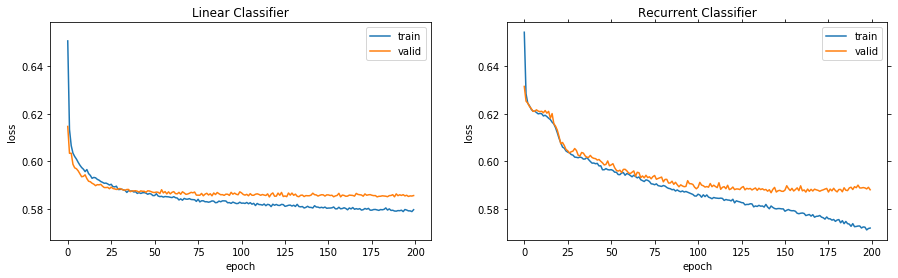

In [9]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(linear_loss[0], label='train')
ax0.plot(linear_loss[1], label='valid')
ax0.set_title('Linear Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(recurrent_loss[0], label='train')
ax1.plot(recurrent_loss[1], label='valid')
ax1.set_title('Recurrent Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.show()

### Testing the trained models

In [10]:
## Load the saved models

# Linear
linear_classifier.load_state_dict(
    torch.load('linear_classifier.pt'))

# Recurrent
recurrent_classifier.load_state_dict(
    torch.load('recurrent_classifier.pt'))

print('Models loaded successfully')

Models loaded successfully


In [11]:
## Test models

print('Linear Classifier')
loss = validate(linear_classifier, test_dataloader, verbose=True)

print('\nRecurrent Classifier')
loss = validate(recurrent_classifier, test_dataloader, verbose=True)

Linear Classifier
	Validation ... loss:  0.5771
		TP: 3077	FP: 1740	OP: 4817
		FN: 1210	TN: 3507	ON: 4717
		CP: 4287	CN: 5247
	Accuracy: 69.06%	Precision:  0.64	Recall:  0.72

Recurrent Classifier
	Validation ... loss:  0.5780
		TP: 2592	FP: 1301	OP: 3893
		FN: 1695	TN: 3946	ON: 5641
		CP: 4287	CN: 5247
	Accuracy: 68.58%	Precision:  0.67	Recall:  0.60
